In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report


In [2]:
df = pd.read_csv("../data/cleaned_data.csv")
df.head()


,Previous_Score,Hours_Studied,Attendance,Assignments_Completed,Sleep_Hours,Participation,Final_Score,Pass_Fail
0,69.9,1.83,82.6,7,6.0,0,70.6,1
1,50.9,2.55,36.8,4,5.9,0,40.1,1
2,74.4,2.09,60.1,8,9.1,2,58.9,1
3,100.0,2.68,64.4,4,9.8,2,74.9,1
4,48.0,3.18,65.2,8,5.6,2,46.0,1


In [3]:
feature_cols = [
    'Hours_Studied', 'Attendance', 'Previous_Score',
    'Assignments_Completed', 'Sleep_Hours', 'Participation'
]

X = df[feature_cols]
y_reg = df["Final_Score"]      # Regression
y_clf = df["Pass_Fail"]        # Classification


In [4]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)


In [5]:
numeric_features = feature_cols

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features)
])


In [6]:
pipe_rf_reg = Pipeline(steps=[
    ("preproc", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])


In [7]:
param_grid_reg = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 8, 12, 15],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}


In [8]:
gs_reg = GridSearchCV(
    estimator=pipe_rf_reg,
    param_grid=param_grid_reg,
    scoring="r2",
    cv=3,
    n_jobs=-1,
    verbose=2
)

gs_reg.fit(X_train_reg, y_train_reg)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [None, 8, ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...], 'model__n_estimators': [100, 200, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...)]"


In [9]:
print("Best Regression params:", gs_reg.best_params_)
print("Best CV R2:", gs_reg.best_score_)

best_reg = gs_reg.best_estimator_

y_pred_reg = best_reg.predict(X_test_reg)

print("Test RMSE:", mean_squared_error(y_test_reg, y_pred_reg))
print("Test R2:", r2_score(y_test_reg, y_pred_reg))


Best Regression params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best CV R2: 0.9687530216717991
Test RMSE: 8.069545907592602
Test R2: 0.9722989083939709


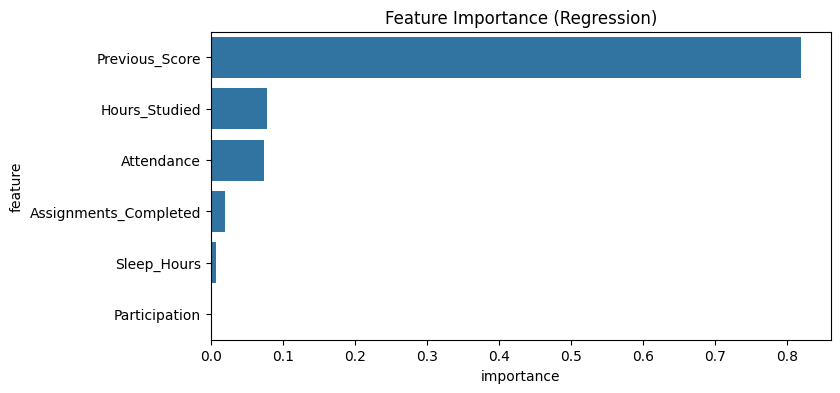

,feature,importance
2,Previous_Score,0.819603
0,Hours_Studied,0.078018
1,Attendance,0.074127
3,Assignments_Completed,0.019999
4,Sleep_Hours,0.006594
5,Participation,0.001660


In [10]:
importances = best_reg.named_steps["model"].feature_importances_
fi_df = pd.DataFrame({"feature": feature_cols, "importance": importances}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x="importance", y="feature", data=fi_df)
plt.title("Feature Importance (Regression)")
plt.show()

fi_df


In [11]:
pipe_rf_clf = Pipeline(steps=[
    ("preproc", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])


In [12]:
param_grid_clf = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 8, 12, 15],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}


In [13]:
gs_clf = GridSearchCV(
    estimator=pipe_rf_clf,
    param_grid=param_grid_clf,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=2
)

gs_clf.fit(X_train_clf, y_train_clf)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [None, 8, ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...], 'model__n_estimators': [100, 200, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...)]"


In [14]:
print("Best Classifier params:", gs_clf.best_params_)
print("Best CV Accuracy:", gs_clf.best_score_)

best_clf = gs_clf.best_estimator_

y_pred_clf = best_clf.predict(X_test_clf)

print("Test Accuracy:", accuracy_score(y_test_clf, y_pred_clf))
print(classification_report(y_test_clf, y_pred_clf))


Best Classifier params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best CV Accuracy: 0.9610416666666667
Test Accuracy: 0.9525
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       269
           1       0.97      0.97      0.97       931

    accuracy                           0.95      1200
   macro avg       0.93      0.93      0.93      1200
weighted avg       0.95      0.95      0.95      1200



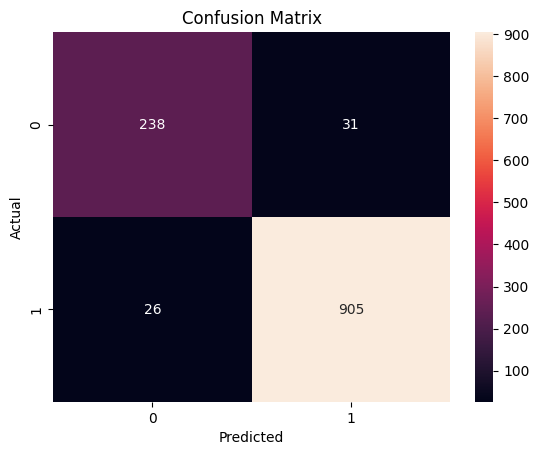

In [15]:
cm = pd.crosstab(y_test_clf, y_pred_clf)

sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [16]:
import os
os.makedirs("../models", exist_ok=True)

joblib.dump(best_reg, "../models/best_random_forest_regression.pkl")
joblib.dump(best_clf, "../models/best_random_forest_classifier.pkl")

print("Tuned models saved successfully!")


Tuned models saved successfully!


In [17]:
import os, json, numpy as np
from datetime import datetime


def safe_imports():
    try:
        from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                                     accuracy_score, classification_report, confusion_matrix)
        return {
            "mean_absolute_error": mean_absolute_error,
            "mean_squared_error": mean_squared_error,
            "r2_score": r2_score,
            "accuracy_score": accuracy_score,
            "classification_report": classification_report,
            "confusion_matrix": confusion_matrix
        }
    except Exception as e:
        return {}

metrics = safe_imports()

os.makedirs("../models", exist_ok=True)
template_path = "../reports/Model_Tuning_Report.txt"
filled_path = "../reports/Model_Tuning_Report_Filled.txt"

# Basic template
template = f"""Model Tuning Report
Generated: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC
====================================================

Dataset
-------
File: ../data/cleaned_data.csv
Features used:
- Hours_Studied
- Attendance
- Previous_Score
- Assignments_Completed
- Sleep_Hours
- Participation

Splits
------
- Regression: train/test split (random_state=42)
- Classification: train/test split (random_state=42, stratify=y_clf)

--- AUTO-FILL SECTION BELOW WILL BE POPULATED IF YOU'VE RUN GRIDSEARCH / TRAINING IN THIS SESSION ---
PLACEHOLDERS:
- <BEST_REG_PARAMS>, <BEST_REG_CV_R2>, <REG_TEST_MAE>, <REG_TEST_RMSE>, <REG_TEST_R2>, <REG_FEATURE_IMPORTANCES>
- <BEST_CLF_PARAMS>, <BEST_CLF_CV_ACC>, <CLF_TEST_ACC>, <CLF_CLASS_REPORT>, <CLF_CONF_MATRIX>, <CLF_FEATURE_IMPORTANCES>

Notes:
- Use the helper snippet included at the end to re-generate a filled report inside this environment.

Helper snippet (already executed by this cell if possible):
- If your variables exist (gs_reg, best_reg, X_test_reg, y_test_reg, gs_clf, best_clf, X_test_clf, y_test_clf),
  this cell will create {os.path.basename(filled_path)} with computed metrics and feature importances.
"""

# Write the template file
with open(template_path, "w", encoding="utf-8") as f:
    f.write(template)

print(f"Template saved to: {template_path}")

# Attempt to auto-fill if variables exist in the notebook session
auto_report_lines = []
can_fill = True
required_reg_vars = ["gs_reg", "best_reg", "X_test_reg", "y_test_reg"]
required_clf_vars = ["gs_clf", "best_clf", "X_test_clf", "y_test_clf"]

# Check presence
for name in required_reg_vars + required_clf_vars:
    if name not in globals():
        can_fill = False
        break

if not metrics:
    can_fill = False

if not can_fill:
    print("Auto-fill skipped: required variables or sklearn metrics unavailable in this session.")
    print(f"If you want auto-fill, ensure the following variables exist: {required_reg_vars + required_clf_vars}")
else:
    try:
        # REGRESSION
        reg_pred = best_reg.predict(X_test_reg)
        mae = float(metrics["mean_absolute_error"](y_test_reg, reg_pred))
        rmse = float(np.sqrt(metrics["mean_squared_error"](y_test_reg, reg_pred)))
        r2 = float(metrics["r2_score"](y_test_reg, reg_pred))
        best_reg_params = gs_reg.best_params_ if hasattr(gs_reg, "best_params_") else "N/A"
        best_reg_cv = float(gs_reg.best_score_) if hasattr(gs_reg, "best_score_") else "N/A"

        # importances
        try:
            reg_importances = best_reg.named_steps["model"].feature_importances_
            # try to get feature names in sensible order
            feature_names = globals().get("feature_cols", None) or globals().get("numeric_features", None) or ['Hours_Studied','Attendance','Previous_Score','Assignments_Completed','Sleep_Hours','Participation']
            fi_list = sorted(list(zip(feature_names, reg_importances)), key=lambda x: x[1], reverse=True)
        except Exception as e:
            fi_list = str(e)

        # CLASSIFICATION
        clf_pred = best_clf.predict(X_test_clf)
        acc = float(metrics["accuracy_score"](y_test_clf, clf_pred))
        best_clf_params = gs_clf.best_params_ if hasattr(gs_clf, "best_params_") else "N/A"
        best_clf_cv = float(gs_clf.best_score_) if hasattr(gs_clf, "best_score_") else "N/A"
        class_report = metrics["classification_report"](y_test_clf, clf_pred, zero_division=0)
        conf_mat = metrics["confusion_matrix"](y_test_clf, clf_pred).tolist()
        try:
            clf_importances = best_clf.named_steps["model"].feature_importances_
            feature_names = globals().get("feature_cols", None) or globals().get("numeric_features", None) or ['Hours_Studied','Attendance','Previous_Score','Assignments_Completed','Sleep_Hours','Participation']
            fi_list_clf = sorted(list(zip(feature_names, clf_importances)), key=lambda x: x[1], reverse=True)
        except Exception as e:
            fi_list_clf = str(e)

        # Build filled report
        auto_report_lines.append("Model Tuning Report (AUTO-FILLED)")
        auto_report_lines.append("="*50)
        auto_report_lines.append("\nREGRESSION (RandomForestRegressor)")
        auto_report_lines.append(f"Best params (GridSearchCV): {best_reg_params}")
        auto_report_lines.append(f"Best CV score (R2): {best_reg_cv}")
        auto_report_lines.append(f"Test MAE : {mae}")
        auto_report_lines.append(f"Test RMSE: {rmse}")
        auto_report_lines.append(f"Test R2  : {r2}")
        auto_report_lines.append("\nFeature importances (regression):")
        if isinstance(fi_list, str):
            auto_report_lines.append(f"  {fi_list}")
        else:
            for f,v in fi_list:
                auto_report_lines.append(f" - {f}: {v}")

        auto_report_lines.append("\nCLASSIFICATION (RandomForestClassifier)")
        auto_report_lines.append(f"Best params (GridSearchCV): {best_clf_params}")
        auto_report_lines.append(f"Best CV score (Accuracy): {best_clf_cv}")
        auto_report_lines.append(f"Test Accuracy: {acc}")
        auto_report_lines.append("\nClassification report:\n")
        auto_report_lines.append(class_report)
        auto_report_lines.append("\nConfusion matrix (rows=Actual, cols=Predicted):")
        auto_report_lines.append(str(conf_mat))
        auto_report_lines.append("\nFeature importances (classification):")
        if isinstance(fi_list_clf, str):
            auto_report_lines.append(f"  {fi_list_clf}")
        else:
            for f,v in fi_list_clf:
                auto_report_lines.append(f" - {f}: {v}")

        # Save auto-filled report
        with open(filled_path, "w", encoding="utf-8") as fh:
            fh.write("\n".join(auto_report_lines))

        print(f"Auto-filled report saved to: {filled_path}")
    except Exception as e:
        print("Auto-fill failed with error:", e)
        print("Template file still created at:", template_path)

# Provide both paths for convenience
print("Files available:")
print(" - Template:", template_path)
print(" - Filled (if created):", filled_path)


Template saved to: ../reports/Model_Tuning_Report.txt


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18952\1314833426.py:28: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  Generated: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC


Auto-filled report saved to: ../reports/Model_Tuning_Report_Filled.txt
Files available:
 - Template: ../reports/Model_Tuning_Report.txt
 - Filled (if created): ../reports/Model_Tuning_Report_Filled.txt
